# Import libraries
This notebook is built based on https://github.com/mginolin/standax/tree/main/notebooks from Madeleine Ginolin

In [48]:
import numpy as np
import pandas as pd
from standax import standardisation
from astropy.cosmology import Planck18
from scipy import stats
import jax.numpy as jnp

# Import sample

In [49]:
df = pd.read_parquet("../data/inference_data_frame.parquet")
new_cols = ["cov_mag_c", "cov_mag_x1", "cov_x1_c"]
df[new_cols] = 0.0
df = df.rename(columns={"magobs": "mag"})
df = df.rename(columns={"magobs_err": "mag_err"})
df = df.rename(columns={"prompt": "h_low"})
df = df.rename(columns={"localcolor": "localrestframe_gz"})
df = df.rename(columns={"localcolor_err": "localrestframe_gz_err"})
df = df.rename(columns={"mass": "globalmass"})
df = df.rename(columns={"mass_err": "globalmass_err"})


# df["h_low"] = stats.norm.cdf(1, loc=df["localrestframe_gz"], scale=df["localrestframe_gz_err"])
df["h_low_err"] = 1e-4

In [50]:
print(df.head())

         mag   mag_err        x1    x1_err         c     c_err  globalmass  \
0  15.856099  0.046536 -0.692000  0.193011 -0.067501  0.027648   10.258641   
1  21.208964  0.031591  0.404820  0.269855  0.101516  0.026374    9.398611   
2  20.739946  0.047440  0.729737  0.171259 -0.075723  0.035339    9.303786   
3  20.768116  0.039658  0.483560  0.069505  0.177118  0.035070    8.855483   
4  20.885029  0.044541 -1.517266  0.150526  0.166695  0.030757   10.557167   

   globalmass_err  localrestframe_gz  localrestframe_gz_err  h_low        z  \
0        0.101401           1.426912               0.026938      0  0.02655   
1        0.101694           0.729359               0.036563      1  0.19755   
2        0.101646           0.703174               0.029868      1  0.19655   
3        0.101425           0.674147               0.017637      1  0.14715   
4        0.101706           1.426447               0.038647      0  0.14685   

   cov_mag_c  cov_mag_x1  cov_x1_c  h_low_err  
0       

In [51]:
data_to_fit = df[["mag", "mag_err", "x1", "x1_err", "c", "c_err", "h_low", "h_low_err",
                    "cov_mag_c", "cov_mag_x1", "cov_x1_c"]].dropna()

residuals = df['mag'] - Planck18.distmod(df['z']).value + 19.3
data_to_fit['mag'] = residuals

In [52]:
print(data_to_fit.head())

        mag   mag_err        x1    x1_err         c     c_err  h_low  \
0 -0.240001  0.046536 -0.692000  0.193011 -0.067501  0.027648      0   
1  0.512266  0.031591  0.404820  0.269855  0.101516  0.026374      1   
2  0.055524  0.047440  0.729737  0.171259 -0.075723  0.035339      1   
3  0.776497  0.039658  0.483560  0.069505  0.177118  0.035070      1   
4  0.898246  0.044541 -1.517266  0.150526  0.166695  0.030757      0   

   h_low_err  cov_mag_c  cov_mag_x1  cov_x1_c  
0     0.0001        0.0         0.0       0.0  
1     0.0001        0.0         0.0       0.0  
2     0.0001        0.0         0.0       0.0  
3     0.0001        0.0         0.0       0.0  
4     0.0001        0.0         0.0       0.0  


# Fit sample with total chi2

In [53]:
init = {"coefs": jnp.asarray([-0.273, -0.085,  3.3, 0.17], dtype="float32"),
        "xbreak": jnp.asarray(-0.5, dtype="float32")}

(best_params_l, sigmaint_l, mcmc_l), this_l = standardisation.standardise_snia(data_to_fit,
                                                      init=init, 
                                                      xkeys=["x1", "c", "h_low"], 
                                                      sigmaint_guess=0.15, 
                                                      model="brokenlinear", 
                                                      nfetch=0, verbose=True,
                                                     lmbda=1e4, fit_method="tncg")

fitting using <function fit_tncg at 0x7f3ad810a5c0> using guess: {'xbreak': Array(-0.5, dtype=float32), 'offset': Array(0., dtype=float32), 'x_model': Array([[-0.6920004 ,  0.4048196 ,  0.7297365 , ..., -1.1916441 ,
         0.47277993, -1.696849  ],
       [-0.06750128,  0.10151613, -0.07572332, ...,  0.04359904,
         0.00542525,  0.20679206],
       [ 0.        ,  1.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ]], dtype=float32), 'coefs': Array([-0.273, -0.085,  3.3  ,  0.17 ], dtype=float32)}
 -> fitting options {'lmbda': 10000.0, 'sigmaint': 0.15}
running mcmc now with 500 sampler (end 10% warmup)
using sigmaint = 0.15 for mcmc


In [54]:
# alpha = best_params_l['coefs'][0]
# chain_alpha = mcmc_l.get_samples()['coefs'][:,0]
# alpha_err = np.sqrt(np.sum((chain_alpha-alpha)**2)/len(chain_alpha))
# beta = best_params_l['coefs'][1]
# chain_beta = mcmc_l.get_samples()['coefs'][:,1]
# beta_err = np.sqrt(np.sum((chain_beta-beta)**2)/len(chain_beta))
# step = best_params_l['coefs'][2]
# chain_step = mcmc_l.get_samples()['coefs'][:,2]
# step_err = np.sqrt(np.sum((chain_step-step)**2)/len(chain_step))
# offset = best_params_l['offset']
# chain_offset = mcmc_l.get_samples()['offset']
# offset_err = np.sqrt(np.sum((chain_offset-offset)**2)/len(chain_offset))

In [55]:
alpha_low = best_params_l['coefs'][0]
chain_alpha_low = mcmc_l.get_samples()['coefs'][:,0]
alpha_low_err = np.sqrt(np.sum((chain_alpha_low-alpha_low)**2)/len(chain_alpha_low))
alpha_high = best_params_l['coefs'][1]
chain_alpha_high = mcmc_l.get_samples()['coefs'][:,1]
alpha_high_err = np.sqrt(np.sum((chain_alpha_high-alpha_high)**2)/len(chain_alpha_high))
beta = best_params_l['coefs'][2]
chain_beta = mcmc_l.get_samples()['coefs'][:,2]
beta_err = np.sqrt(np.sum((chain_beta-beta)**2)/len(chain_beta))
step = best_params_l['coefs'][3]
chain_step = mcmc_l.get_samples()['coefs'][:,3]
step_err = np.sqrt(np.sum((chain_step-step)**2)/len(chain_step))
offset = best_params_l['offset']
chain_offset = mcmc_l.get_samples()['offset']
offset_err = np.sqrt(np.sum((chain_offset-offset)**2)/len(chain_offset))
xbreak = best_params_l['xbreak']
chain_xbreak = mcmc_l.get_samples()['xbreak']
xbreak_err = np.sqrt(np.sum((chain_xbreak-xbreak)**2)/len(chain_xbreak))

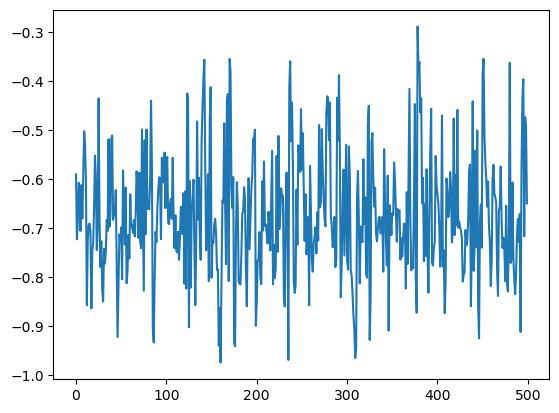

In [56]:
import matplotlib.pyplot as plt
plt.plot(chain_xbreak)
plt.show()

In [57]:
# Print parameters with errors in a clear table-like format
print(f"{'Parameter':<10} {'Value':>10} {'Error':>10}")
# print(f"{'alpha':<10} {alpha:>10.4f} {alpha_err:>10.4f}")
print(f"{'offset':<10} {offset:>10.4f} {offset_err:>10.4f}")
print(f"{'alpha low':<10} {alpha_low:>10.4f} {alpha_low_err:>10.4f}")
print(f"{'alpha high':<10} {alpha_high:>10.4f} {alpha_high_err:>10.4f}")
print(f"{'beta':<10} {beta:>10.4f} {beta_err:>10.4f}")
print(f"{'sigmaint':<10} {sigmaint_l[-1]:>10.4f}     unkown")

Parameter       Value      Error
offset        -0.1989     0.0356
alpha low     -0.3123     0.0232
alpha high    -0.0766     0.0142
beta           3.4253     0.0507
sigmaint       0.1500     unkown


In [58]:
samples = np.vstack([chain_alpha_low, chain_alpha_high, chain_beta, chain_offset, chain_step]).T

## Save posterior

In [59]:
np.save("../data/results/standax_posterior.npy", samples)